In [14]:
import matplotlib.pyplot as plt
import os
import missingno as msno
import numpy as np
import seaborn as sns
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

# Exploratory Data Analysis


In [3]:
df15 = pd.read_csv('dataset/2015-building-energy-benchmarking.csv')
df16 = pd.read_csv('dataset/2016-building-energy-benchmarking.csv')

In [4]:
df15.describe()

,OSEBuildingID,DataYear,CouncilDistrictCode,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,...,NaturalGas(therms),NaturalGas(kBtu),OtherFuelUse(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),2010 Census Tracts,Seattle Police Department Micro Community Policing Plan Areas,City Council Districts,SPD Beats,Zip Codes
count,3340.000000,3340.0,3340.000000,3340.000000,3340.000000,3332.000000,3.340000e+03,3340.000000,3.340000e+03,3.204000e+03,...,3.330000e+03,3.330000e+03,3.330000e+03,3330.000000,3330.000000,224.000000,3338.000000,213.000000,3338.000000,3340.000000
mean,20522.168263,2015.0,4.450898,1967.624850,1.035629,4.682173,9.077289e+04,11054.032335,7.971886e+04,7.488154e+04,...,1.253304e+04,1.253304e+06,7.142301e+03,110.094102,0.985339,123.062500,32.380168,1.347418,24.825644,18786.680240
std,11511.515874,0.0,2.127203,32.949847,0.784463,5.458460,1.493058e+05,35296.330507,1.292314e+05,1.236249e+05,...,4.415142e+04,4.415142e+06,1.962790e+05,409.450179,1.637172,5.812128,19.907567,0.477272,15.006287,588.604192
min,1.000000,2015.0,1.000000,1900.000000,1.000000,0.000000,2.000000e+04,-3.000000,-5.055000e+04,5.872000e+03,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,116.000000,1.000000,1.000000,1.000000,17916.000000
25%,19921.750000,2015.0,3.000000,1947.000000,1.000000,2.000000,2.848700e+04,0.000000,2.668300e+04,2.500000e+04,...,0.000000e+00,0.000000e+00,0.000000e+00,9.265000,0.080000,117.000000,14.000000,1.000000,10.000000,18379.000000
50%,22977.000000,2015.0,4.000000,1973.000000,1.000000,4.000000,4.385500e+04,0.000000,4.132600e+04,3.900000e+04,...,2.945500e+03,2.945770e+05,0.000000e+00,32.740000,0.460000,123.000000,33.000000,1.000000,26.000000,18390.000000
75%,25748.000000,2015.0,7.000000,1996.000000,1.000000,5.000000,8.842800e+04,4304.250000,7.872600e+04,7.206750e+04,...,1.115325e+04,1.115366e+06,0.000000e+00,88.642500,1.180000,125.500000,50.000000,2.000000,38.000000,19576.000000
max,50059.000000,2015.0,7.000000,2015.000000,39.000000,99.000000,2.200000e+06,512608.000000,2.200000e+06,1.719643e+06,...,1.364484e+06,1.364484e+08,8.269669e+06,11824.890000,31.380000,135.000000,61.000000,2.000000,51.000000,19584.000000


In [5]:
df16.describe()

,OSEBuildingID,DataYear,ZipCode,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,...,SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),Comments,TotalGHGEmissions,GHGEmissionsIntensity
count,3376.000000,3376.0,3360.000000,3376.000000,3376.000000,3376.000000,3376.000000,3368.000000,3376.000000,3.376000e+03,...,3.371000e+03,3.370000e+03,3.367000e+03,3.367000e+03,3.367000e+03,3.367000e+03,3.367000e+03,0.0,3367.000000,3367.000000
mean,21208.991114,2016.0,98116.949107,4.439277,47.624033,-122.334795,1968.573164,1.106888,4.709123,9.483354e+04,...,5.403667e+06,5.276726e+06,2.745959e+05,1.086639e+06,3.707612e+06,1.368505e+04,1.368505e+06,NaN,119.723971,1.175916
std,12223.757015,0.0,18.615205,2.120625,0.047758,0.027203,33.088156,2.108402,5.494465,2.188376e+05,...,2.161063e+07,1.593879e+07,3.912173e+06,4.352478e+06,1.485066e+07,6.709781e+04,6.709781e+06,NaN,538.832227,1.821452
min,1.000000,2016.0,98006.000000,1.000000,47.499170,-122.414250,1900.000000,0.000000,0.000000,1.128500e+04,...,0.000000e+00,0.000000e+00,0.000000e+00,-3.382680e+04,-1.154170e+05,0.000000e+00,0.000000e+00,NaN,-0.800000,-0.020000
25%,19990.750000,2016.0,98105.000000,3.000000,47.599860,-122.350662,1948.000000,1.000000,2.000000,2.848700e+04,...,9.251286e+05,9.701822e+05,0.000000e+00,1.874229e+05,6.394870e+05,0.000000e+00,0.000000e+00,NaN,9.495000,0.210000
50%,23112.000000,2016.0,98115.000000,4.000000,47.618675,-122.332495,1975.000000,1.000000,4.000000,4.417500e+04,...,1.803753e+06,1.904452e+06,0.000000e+00,3.451299e+05,1.177583e+06,3.237538e+03,3.237540e+05,NaN,33.920000,0.610000
75%,25994.250000,2016.0,98122.000000,7.000000,47.657115,-122.319407,1997.000000,1.000000,5.000000,9.099200e+04,...,4.222455e+06,4.381429e+06,0.000000e+00,8.293178e+05,2.829632e+06,1.189033e+04,1.189034e+06,NaN,93.940000,1.370000
max,50226.000000,2016.0,98272.000000,7.000000,47.733870,-122.220966,2015.000000,111.000000,99.000000,9.320156e+06,...,8.739237e+08,4.716139e+08,1.349435e+08,1.925775e+08,6.570744e+08,2.979090e+06,2.979090e+08,NaN,16870.980000,34.090000


In [6]:
df15.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,Location,CouncilDistrictCode,Neighborhood,YearBuilt,...,GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,Comment,ComplianceStatus,Outlier,2010 Census Tracts,Seattle Police Department Micro Community Policing Plan Areas,City Council Districts,SPD Beats,Zip Codes
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,"{'latitude': '47.61219025', 'longitude': '-122...",7,DOWNTOWN,1927,...,2.64,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,659000220,"{'latitude': '47.61310583', 'longitude': '-122...",7,DOWNTOWN,1996,...,2.38,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081
2,3,2015,NonResidential,Hotel,WESTIN HOTEL,659000475,"{'latitude': '47.61334897', 'longitude': '-122...",7,DOWNTOWN,1969,...,1.92,Yes,NaN,Compliant,NaN,NaN,56.0,NaN,31.0,18081
3,5,2015,NonResidential,Hotel,HOTEL MAX,659000640,"{'latitude': '47.61421585', 'longitude': '-122...",7,DOWNTOWN,1926,...,31.38,No,NaN,Compliant,High Outlier,NaN,56.0,NaN,31.0,18081
4,8,2015,NonResidential,Hotel,WARWICK SEATTLE HOTEL,659000970,"{'latitude': '47.6137544', 'longitude': '-122....",7,DOWNTOWN,1980,...,4.02,No,NaN,Compliant,NaN,NaN,56.0,NaN,31.0,19576


<AxesSubplot:ylabel='None'>

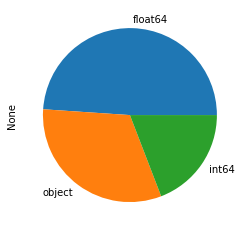

In [7]:
df15.dtypes.value_counts().plot.pie()

In [8]:
df15.dtypes

OSEBuildingID                                                      int64
DataYear                                                           int64
BuildingType                                                      object
PrimaryPropertyType                                               object
PropertyName                                                      object
TaxParcelIdentificationNumber                                     object
Location                                                          object
CouncilDistrictCode                                                int64
Neighborhood                                                      object
YearBuilt                                                          int64
NumberofBuildings                                                  int64
NumberofFloors                                                   float64
PropertyGFATotal                                                   int64
PropertyGFAParking                                 

In [9]:
# df15.BuildingType.unique()
df15.BuildingType.unique()

array(['NonResidential', 'Nonresidential COS', 'Multifamily MR (5-9)',
       'SPS-District K-12', 'Multifamily LR (1-4)', 'Campus',
       'Multifamily HR (10+)'], dtype=object)

In [10]:
for type in df15.select_dtypes(object):
	print('unique values for: ', type)
	print(df15.loc[:,type].unique())
	print()

unique values for:  BuildingType
['NonResidential' 'Nonresidential COS' 'Multifamily MR (5-9)'
 'SPS-District K-12' 'Multifamily LR (1-4)' 'Campus'
 'Multifamily HR (10+)']

unique values for:  PrimaryPropertyType
['Hotel' 'Other' 'Mid-Rise Multifamily' 'Mixed Use Property' 'K-12 School'
 'College/University' 'Small- and Mid-Sized Office'
 'Self-Storage Facility\n' 'Distribution Center' 'Large Office'
 'Retail Store' 'Low-Rise Multifamily' 'Senior Care Community'
 'Medical Office' 'Hospital' 'Residence Hall/Dormitory'
 'Non-Refrigerated Warehouse' 'Distribution Center\n' 'SPS-District K-12'
 'Worship Facility' 'Supermarket/Grocery Store' 'Laboratory'
 'Self-Storage Facility' 'Refrigerated Warehouse' 'High-Rise Multifamily'
 'Restaurant\n' 'Restaurant']

unique values for:  PropertyName
['MAYFLOWER PARK HOTEL' 'PARAMOUNT HOTEL' 'WESTIN HOTEL' ... 'CIRRUS'
 'WEDGEWOOD ESTATES BLDG A' 'WEDGEWOOD ESTATES BLDG B']

unique values for:  TaxParcelIdentificationNumber
['659000030' '659000220' '

In [18]:
correlations = df15.select_dtypes('float').corr(method="pearson")
correlations = np.abs(correlations)

<AxesSubplot:>

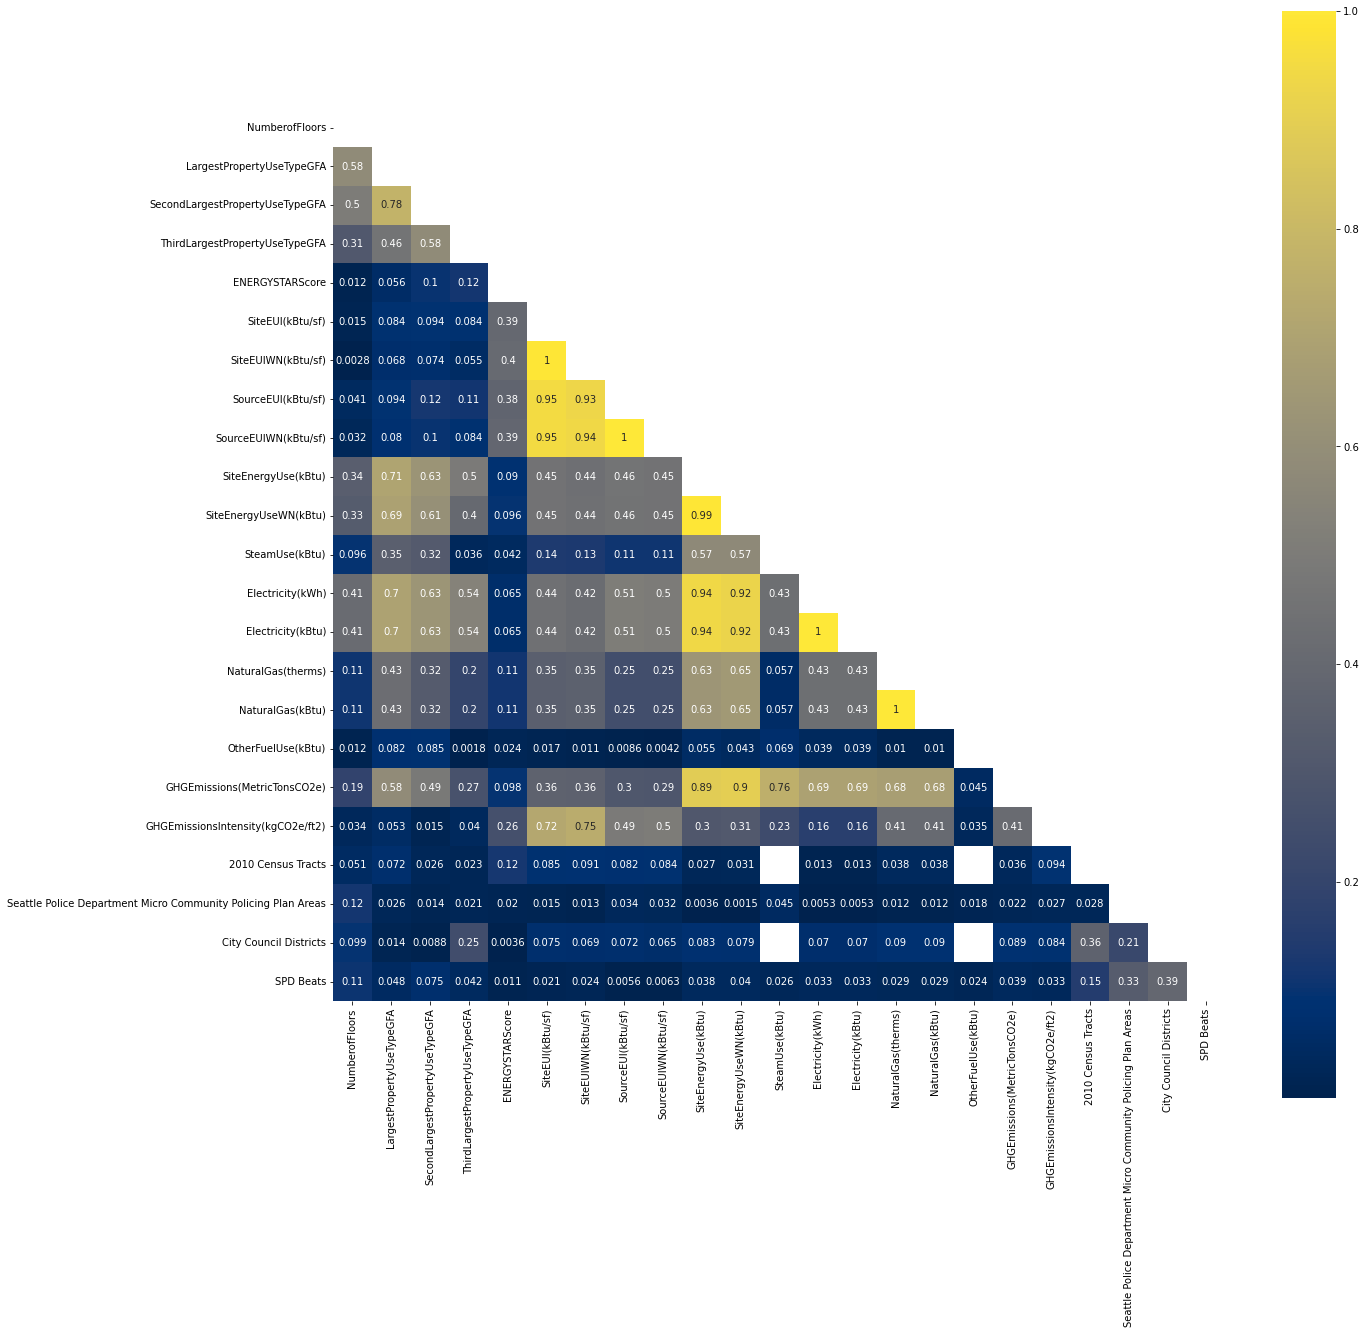

In [19]:
mask = np.zeros_like(correlations)
mask[np.triu_indices_from(mask)] = True
sns.axes_style("white")
plt.subplots(figsize=(20,20))
sns.heatmap(correlations, mask=mask, vmax=1, square=True, xticklabels=correlations.columns, yticklabels=correlations.columns, annot=True, cmap='cividis')